### Tutorial on convolutional graph neural networks

This tutorial is constructed from 
 - A [google collab tutorial](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8?usp=sharing#scrollTo=NgcpV4rjAWy-) on graph neural networks.
 - A [second collab tutorial](https://colab.research.google.com/drive/14OvFnAXggxB8vM4e8vSURUp1TaKnovzX) on node classification using graph neural networks 
 - _Hands-On Graph Neural Networks Using Python_ Maxime Labonne, chapter 6
 - Lectures 6.1-6.4 from [Stanford machine learning course](https://www.youtube.com/watch?v=MH4yvtgAR-4)
 - a variety of other sources

---

### Graph Graph Convolutional Neural Network Basics

I'm going to write this portion of the tutorial assuming that some of you are completely unfamiliar with neural networks while also trying to make some connections for those that have used them. 

Directly applying tools like convolutional neural networks to graphs doesn't work well because each graph has a different structure. That means an approach tuned to one graph won't work well for another. This is a big problem when the only difference between one graph and another is the way that nodes are numbered or the way that the adjacency matrix is formed. The [Stanford graph machine learning course](https://www.youtube.com/watch?v=MH4yvtgAR-4) motivates the graph neural network solution using an analogy to the kinds of convolutional neural networks used in image processing.

---




I'm going to use a different analogy: node centrality. Consider the pinwheel graph

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


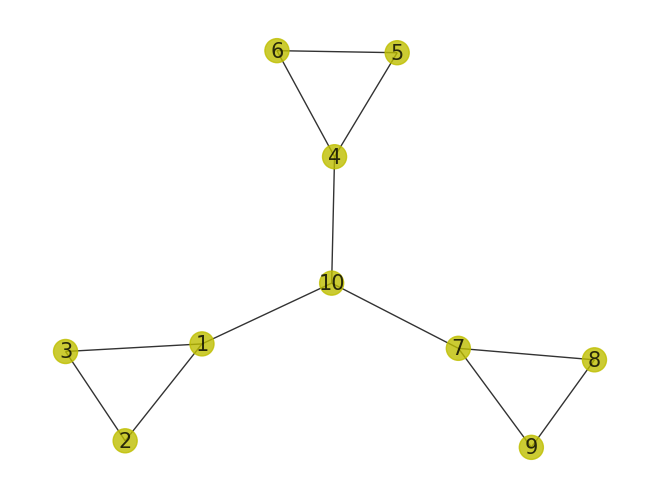

In [47]:
import networkx as nx
from matplotlib import pyplot as plt
pinwheel_graph = nx.Graph()
pinwheel_graph.add_nodes_from([1,2,3,4,5,6,7,8,9,10])
pinwheel_graph.add_edges_from([(1,2),(1,3),(2,3),(4,5),(4,6),(5,6),(7,8),(7,9),(8,9),(1,10),(4,10),(7,10)])
colormap = []
[colormap.append('y') for nodes in pinwheel_graph.nodes()]
#pos = nx.nx_agraph.graphviz_layout(G,prog='neato')
pos = nx.nx_pydot.graphviz_layout(pinwheel_graph,prog="neato")
plt.figure(1)
plt.clf()
nx.draw(pinwheel_graph,pos,with_labels = True,node_color = colormap, node_size = 300,font_size = 15, alpha=0.8)

Recall that a node's eigenvector centrality is computed as the sum of the centralities of its neighbors,

$$ x_i = \lambda^{-1} \sum_{j\in{\rm Neighbors}(i)} x_j $$

This equation can be written in matrix form 

$$ A{\mathbf x} = \lambda {\mathbf x}$$

which is an eigenvalue/eigenvector problem. We choose the eigenvector associated with the largest eigenvalue because that eigenvector is guaranteed to be positive for every node.

Let's compute the eigenvector centrality. 

In [48]:
import numpy as np
A = nx.linalg.adjacency_matrix(pinwheel_graph).toarray()
eigvals, eigvecs = np.linalg.eig(A)
eigvals = [0 if np.abs(val) < 1e-5 else val for val in eigvals] # Manage roundoff error
print(np.round(eigvals,2))

[-2.09  2.51  0.57 -1.   -1.    2.    2.   -1.   -1.   -1.  ]


Find the eigenvalue with the highest value and extract the corresponding eigenvector. The values in that principal eigenvector are all positive. The values of the principal eigenvector are the eigenector centrality values.

In [49]:
def get_largest_eigenvector(eigvals,eigvecs):
    max_val, max_index = 0, 0
    for i in range(len(eigvals)):
        if eigvals[i] > max_val:
            max_val = eigvals[i]
            max_index = i
    return eigvecs[:,max_index]
x = get_largest_eigenvector(eigvals, eigvecs)
print(x)

[0.37686362 0.24889665 0.24889665 0.37686362 0.24889665 0.24889665
 0.37686362 0.24889665 0.24889665 0.44969343]


Plot the centralities for reference.

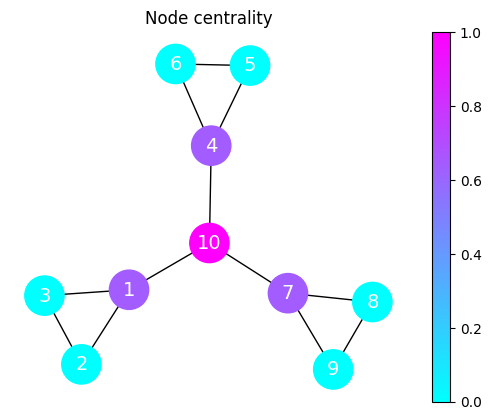

In [50]:
def draw_graph_by_node_centrality(G,pos,centrality, title="Node centrality"):
    # Color a node by it's random walk distance from node zero
    plt.axis('off')
    plt.title(title)
    nx.draw_networkx(G, 
                    pos=pos, 
                    node_color=centrality,
                    node_size=800,
                    cmap='cool',
                    font_size=14,
                    font_color='white')
    sm = plt.cm.ScalarMappable(cmap = 'cool',norm=plt.Normalize(vmin = 0, vmax=1))
    _ = plt.colorbar(sm, ax=plt.gca())
draw_graph_by_node_centrality(pinwheel_graph,pos,x)

The figure shows that node 10 has the highest eigenvector centrality. This is because node 10 "receives" centrality from its neighbors (nodes 1, 4, and 7), who in turn "receive" centrality from their neighbors. We can think of this using a message passing metaphor. 
 - Each node receives messages from its neighbors
 - Each node sums up the messages from its neighbors to form a new message
 - Each node sends this message to its neighbors

After all the messages have been passed, computed, passed again, and so on, everyone reaches a point where the message they compute is exactly the same as what they computed on the previous round of message-passing. The message computed by each agent is the eigenvector centrality. 

We'll see the message-passing metaphor in graph neural networks.

---

#### Idea behind GCNs

A GCN is a graph convolutional neural network. GCNs solve a different problem than the centrality problem. The centrality problem is trying to find the most important nodes in a network. What we are trying to do is more like what deepwalk and node2vec do, namely find nodes that are similar to each other by looking at local graph structures. The difference from deepwalk and node2vec is that each node has a feature. We want to use both
 - node messages, which begin as node features that are passed to a node's neighbors
 - graph structures, which determine which nodes pass messages along to which other nodes.

Let me try to restate this in different words. Recall that the idea of eigenvector centrality is that each node gets a little centrality from its neighbors.  We'll do something analogous here. Each node will receive "messages" from its neighbors. Those messages will be the neighbors' feature vectors. The node's job is to create a new feature vector by aggregating the messages from its neighbors. The first time we do this, each node outputs a new feature vector that just uses messages from immediate neighbors. If a node aggregates messages containing its neighbors' new features, the node creates a second revised feature vector that includes both its own neighbors and its neighbors' neighbors. See [minute 9:20](https://www.youtube.com/watch?v=MH4yvtgAR-4) of the Stanford course.



__What does each node do__

Putting the pieces together, each node does three things.
 - decides from which of its neighbors it will receive messages
 - receives messages
 - aggregates those messages
 - transforms the result of the aggregation so that it can be passed along when future messages are exchanged.

 We will illustrate each of the four steps above using an example from the pinwheel network. We'll also use the figure above as a guide.

__What does the network do?__ 

A GCN takes as input a graph, performs operations on the graph, and outputs information about the graph. 
Thomas Kipf, the first author of the [seminal paper](https://arxiv.org/abs/1609.02907) on graph convolutional neural networks (GCNs) has written a nice [summary](https://tkipf.github.io/graph-convolutional-networks/) of the elements of a GCN. Here's the image from the top of the github post.

<img src="figures/Kipf_figure.png" alt="Kipf's illustration of GCN elements" width = "600">

The inputs and outputs are illustrated by the leftmost and rightmost components of the graph above. Each node in the graph is labeled with some kind of feature vector. These features can range from (a) something like the "one hot" encoding that we used for deep walk and node2vec to (b) a bag of words feature set, which we'll describe later.

The hidden layers of the GCN update the "feature" for each node, which is illustrated in the middle two figures. These two figures illustrate that each node is updated by receiving messages from its neighbors. The three graphs in each of the middle two figures indicate a node update for the purple nodes in the graph.

The output layer takes the output from the last hidden layer and transforms it. The type of transformation depends on what we want to learn about the nodes in the graph. For example, sometimes we want to learn a node embedding similar to what we did in deepwalk and node2vec but using node features to improve the embedding. For another example, we might be given a class labels for some of the nodes on the input graph and we want to learn how to label each node.

#### Details and Example

Let's begin by setting up the pinwheel graph with some node features. The feature vector of each node has three elements. The outer nodes {2,3,4,6,8,9} have node number in the first element of the list and zeroes in the second and third elements. The bridge nodes {1,4,7} has zero for the first and third element, but the node number for the second element. And the hub node has zero for the first and second element, and the node number for the third element.

In [51]:
pinwheel_graph = nx.Graph()
for i in range(0,10):  # give each node a feature. We'll set them in a minute.
    if i in {1,2,4,5,7,8}: pinwheel_graph.add_node(i, feature = [i+1,0,0])
    elif i in {0,3,6}: pinwheel_graph.add_node(i, feature = [0,i+1,0])
    else: pinwheel_graph.add_node(i, feature = [0,0,i+1])
for node in pinwheel_graph.nodes: print(node, pinwheel_graph.nodes[node])
pinwheel_graph.add_edges_from([(0,1),(0,2),(1,2),(3,4),(3,5),(4,5),(6,7),(6,8),(7,8),(0,9),(3,9),(6,9)])


0 {'feature': [0, 1, 0]}
1 {'feature': [2, 0, 0]}
2 {'feature': [3, 0, 0]}
3 {'feature': [0, 4, 0]}
4 {'feature': [5, 0, 0]}
5 {'feature': [6, 0, 0]}
6 {'feature': [0, 7, 0]}
7 {'feature': [8, 0, 0]}
8 {'feature': [9, 0, 0]}
9 {'feature': [0, 0, 10]}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Text(0.5, 1.0, 'Pinwheel network with node features')

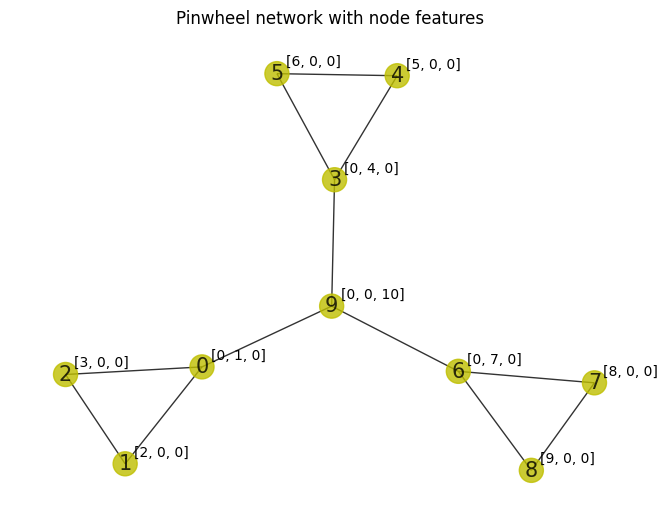

In [52]:
colormap = []
[colormap.append('y') for nodes in pinwheel_graph.nodes()]
#pos = nx.nx_agraph.graphviz_layout(G,prog='neato')
pos = nx.nx_pydot.graphviz_layout(pinwheel_graph,prog="neato")
plt.figure()
plt.clf()
nx.draw(pinwheel_graph,pos,with_labels = True,node_color = colormap, node_size = 300,font_size = 15, alpha=0.8)
for node in pos.keys():
    plt.text(pos[node][0]+5, pos[node][1]+5, str(pinwheel_graph.nodes[node]['feature']))
plt.title("Pinwheel network with node features")


__Step 1: Choose Neighbors.__ Since we're applying this to small networks, we'll just use all of a node's neighbors. This means that we'll use the adjacency matrix to decide which nodes "point to" a node. This is illustrated in the figure above in the middle two figures. Each purple node has a bold edge connecting it to all of its neighbors. We'll assume an undirected graph because that means we can ignore a detail and focus on the core ideas.

When GCNs are applied to large graphs, they use more sophisitcalted neural network techniques to decide which of a node's neighbors send messages to the node. For example, a node might randomly select a handful of its neighbors, receive message from that handful, and ignore every other neighbor.  If I can pull together some slides and a demonstration of this then we'll discuss it in class this semester. If not, I can point you to some good references.


In [53]:
for node in pinwheel_graph.nodes: print(f"node {node}'s neighbors are {list(pinwheel_graph.neighbors(node))}")

node 0's neighbors are [1, 2, 9]
node 1's neighbors are [0, 2]
node 2's neighbors are [0, 1]
node 3's neighbors are [4, 5, 9]
node 4's neighbors are [3, 5]
node 5's neighbors are [3, 4]
node 6's neighbors are [7, 8, 9]
node 7's neighbors are [6, 8]
node 8's neighbors are [6, 7]
node 9's neighbors are [0, 3, 6]



__Step 2: Receive messages.__ The first set of messages that nodes send to each other are just the feature vectors. Represent the features of each node as a row vector:

$$ {\mathbf x}_i = \left[ \begin{array}{cccc}x_{i,1} & x_{i,2} & \ldots & x_{i,n} \end{array}\right] $$

Stack those feature vectors on top of each other to form a big matrix of features

$$ X = \left[ \begin{array}{c} {\mathbf x}_1 \\ {\mathbf x}_2 \\ \vdots \\ {\mathbf x}_n \end{array}\right] $$


In [54]:
import numpy as np
X = np.zeros((len(pinwheel_graph.nodes),len(pinwheel_graph.nodes[1]["feature"])))
for node in pinwheel_graph.nodes:
    X[node,:] = np.array(pinwheel_graph.nodes[node]["feature"])
print(X)

[[ 0.  1.  0.]
 [ 2.  0.  0.]
 [ 3.  0.  0.]
 [ 0.  4.  0.]
 [ 5.  0.  0.]
 [ 6.  0.  0.]
 [ 0.  7.  0.]
 [ 8.  0.  0.]
 [ 9.  0.  0.]
 [ 0.  0. 10.]]


__Step 3: Aggregate Messages.__ Aggregation can occur in several ways in graph neural networks, but there is a really big constraint on aggregating from neighboring nodes in a network. The constraint is that the aggregation can't depend on how the nodes are ordered or numbered. Techincally, we say that the aggregation method must be _permutation invariant_, which just means that permuting the way nodes are numbered shouldn't change the outcome of the aggregation. There are a handful of aggregation methods, but the most simple permutation is averaging. 

Averaging across neighbors is done by the following:

$$ \hat{\mathbf h}_i = \frac{1}{k_i} \sum_{j\in N_i} {\mathbf x} _j $$

I've used a little hat over ${\mathbf h}$ because this is just a stage in the computation done at each hidden layer. The vector $\hat {\mathbf h}_i$ is the average of node $i$'s neighbors. The $h$ stand for "hidden layer".
Notice that we are dividing by the degree of node $i$. If node $i$ has $k_i$ neighbors, then the average of the neighbors feature vectors is just the sum of those feature vectors divided by $k_i$. 

Since we know a lot about networks by now, it is fairly easy to replace the equation above with 

$$ \hat{\mathbf h}_i = \frac{1}{k_i} \sum_{j=1}^{n} A_{ij} {\mathbf x}_j $$

This is analogous to the equation for eigenvector centrality. Instead of saying that my centrality is the sum of my neighbors' centralities, we are saying that my "revised feature" vector is the average of my neighbors' feature vector. In matrix terms, the equation above becomes:

$$ \hat{H} = D^{-1} A X. $$

Matrix $\hat{H}$ stacks each of the modified feature vectors, which are row vectors, on top of each other. Notice that the degree matrix inverse _pre-multiplies_ the adjacency matrix (i.e., $D^{-1}$ is to the left of $A^T$). When we talked about page rank, the degree vector post-multiples the adjacency matrix (i.e., $D^{-1}$ is to the right of $A^T$). The reason for the difference is that page rank normalized importance coming from node $j$, whereas aggregation computes the average of agent $i$ neighbors by summing their values and dividing the number of neighbors, which is $k_i$.


In [55]:
A = nx.linalg.adjacency_matrix(pinwheel_graph).toarray()
D = np.diag([pinwheel_graph.degree[node] for node in pinwheel_graph.nodes])
H = np.linalg.inv(D)@A@X

Let's see if these values make sense. Node 0's neighbors are nodes 1, 2, and 9 with the following characteristics:
 - node 1's feature vector is [2,0,0]
 - node 2's feature vector is [3,0,0]
 - node 9's feature vector is [0,0,10].
  
So, the aggregated value of row 0 should be [2+3, 0, 10] divided by node 0's degree, which is 3, yielding [5/3, 0, 10/3].

[1.67 0.   3.33]


Text(0.5, 1.0, 'Pinwheel network with node features')

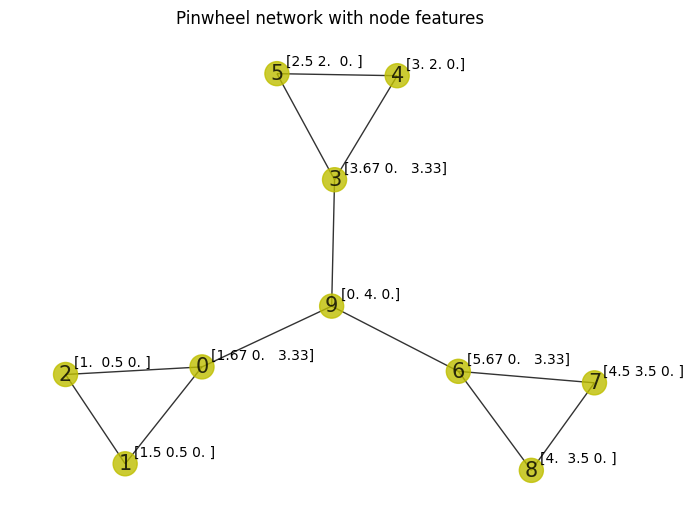

In [56]:

print(np.round(H[0,:],2))
plt.figure()
nx.draw(pinwheel_graph,pos,with_labels = True,node_color = colormap, node_size = 300,font_size = 15, alpha=0.8)
for node in pos.keys():
    plt.text(pos[node][0]+5, pos[node][1]+5, str(np.round(H[node,:],2)))
plt.title("Pinwheel network with node features")

__Fixing a Problem with Step 3.__
Let's pause and consider what we are doing. We are telling a node that it's revised feature vector is the average of its neighbors feature vectors. That means that agent $i$'s revised feature vector doesn't even consider agent $i$'s feature. That doesn't feel "revised" to me -- it feels replaced. 

Specficaly, look at the aggregation of node 9's neighbors. It has a value in the second column, which is because it averaged the features of its neighbor nodes together. But it doesn't have a value in the third column _even though its only non-zero column in the feature vector was column 3. It has lost any tie to its previous feature.

We can fix this by introducing new edges so that each node has a self loop. Introducing self loops is equivalent to defining a new adjacency matrix

$$ \tilde{A} = A + I $$

That naturally modifies the degree matrix by increasing the degree of each node by one

$$ \tilde{D} = D + I $$

Putting the pieces together yields the matrix form

$$ \hat{H} = \tilde{D}^{-1} \tilde{A} X $$


We should see this change in the H matrix. 

In [57]:
A = nx.linalg.adjacency_matrix(pinwheel_graph).toarray()
A = A + np.eye(len(A))
D = np.diag([pinwheel_graph.degree[node] for node in pinwheel_graph.nodes])
D = D + np.eye(len(D))
H = np.linalg.inv(D)@A@X
print(np.round(H[0,:],2))

[1.25 0.25 2.5 ]


Text(0.5, 1.0, 'Pinwheel network with aggregated features')

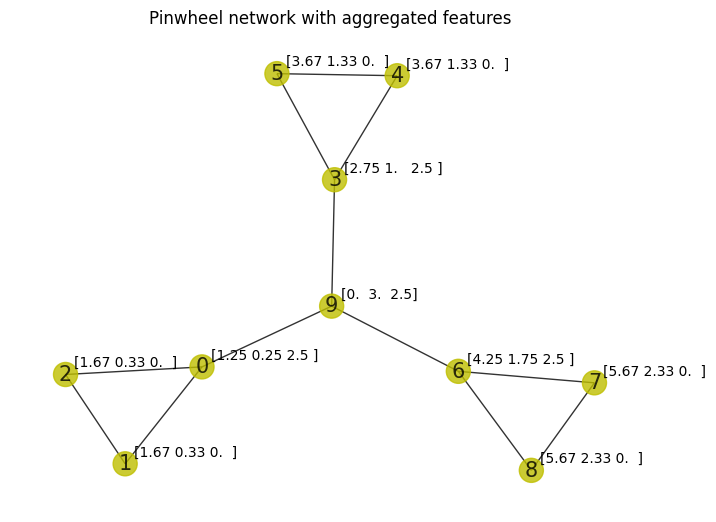

In [58]:
plt.figure()
nx.draw(pinwheel_graph,pos,with_labels = True,node_color = colormap, node_size = 300,font_size = 15, alpha=0.8)
for node in pos.keys():
    plt.text(pos[node][0]+5, pos[node][1]+5, str(np.round(H[node,:],2)))
plt.title("Pinwheel network with aggregated features")


__Fixing another Problem with Step 3.__
In practice, nodes with really high degree end up having more influence than other nodes. This is similar to the problem we encountered with eigenvector and Katz centrality. Our example was Amazon having a lot of outlinks. We solved it by having node $j$ divide its influence equally among its neighbors by taking $A^TD^{-1}$. If we do that, we end up counting degree twice: once before the adjacency matrix and once after it. The solution from the original GNN paper is to compromise: do a little averaging and do a little normalizing. This yields

$$ \hat{H} = \tilde{D}^{-1/2} \tilde{A} \tilde{D}^{-1/2} X $$

The solution in the Stanford class has a slightly different form, but the two forms are equivalent. 

Let's inspect H with this new formulation.


In [59]:
A = nx.linalg.adjacency_matrix(pinwheel_graph).toarray()
A = A + np.eye(len(A))
D = np.diag([pinwheel_graph.degree[node] for node in pinwheel_graph.nodes])
D = D + np.eye(len(D))
H = np.linalg.inv(np.power(D,0.5))@A@np.linalg.inv(np.power(D,0.5))@X
print(H[0,:])

[1.44337567 0.25       2.5       ]


Let's inspect what the features of the nodes are after these aggregation operations.

Text(0.5, 1.0, 'Pinwheel network with aggregated features')

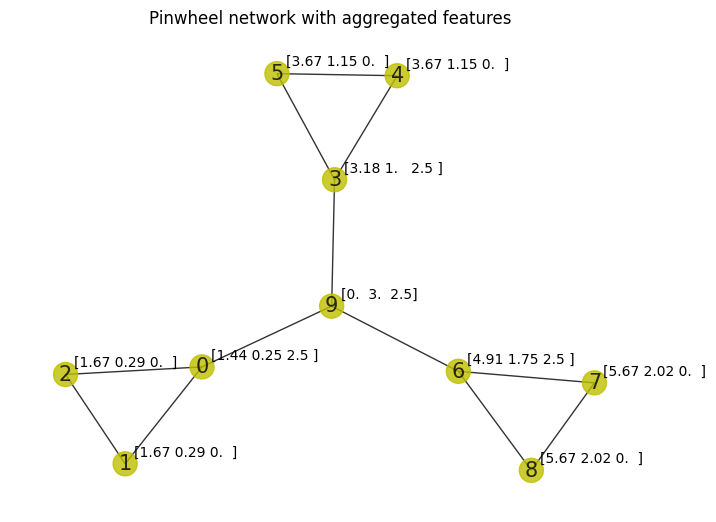

In [60]:
plt.figure()
nx.draw(pinwheel_graph,pos,with_labels = True,node_color = colormap, node_size = 300,font_size = 15, alpha=0.8)
for node in pos.keys():
    plt.text(pos[node][0]+5, pos[node][1]+5, str(np.round(H[node,:],2)))
plt.title("Pinwheel network with aggregated features")

Let's see if this makes sense. Consider nodes 0, 3, and 6. They aggregated information into the third column of the feature vector because they were connected to node 9 (which had a value in the third column). They also aggregated information into the first column since they were connected to leaf nodes (which had values in the first column). By contrast, node 9 has information in the second column because it aggregated information only from nodes 0, 6, and 3 (which had values in the second column) but the value in the first column is still 0 since it didn't aggregate information from the leaf nodes.


__An Aside: The normalized Laplacian.__
We've seen this matrix form, namely when we were using spectral methods to approximate the optimal graph cut.


__Step 4: Transform Messages Part 1 -- Weighting.__ Neural networks have multiple layers, and each layer takes an input, does some transformation to the input, and then passes it along to the next layer of the network. Transformations have two parts, which I'll call _weighting_ and _squashing_. Let's talk about weighting first.

Each layer multiples what is passed to it by weights. These weights are what is learned by the kind of neural network that we are considering. If you think about the weights as a way of saying what is important in the input, then learning in neural networks is the process of learning what is important. We'll just create a big weight matrix $W$ and multiply it after the aggregation (averaging) occurs. This gives

$$ {\mathbf h}_i = \frac{1}{k_i} \sum_{j=1}^{n} A_{ij} {\mathbf x}_j W$$

Notice that the little hat on ${\mathbf h}$ is gone. Layers of the neural network are often called "hidden layers", and the letter $h$ stands for "hidden". Putting all the other steps to aggregation together gives us the matrix of hidden layer values

$$ H = \tilde{D}^{-1/2} \tilde{A} \tilde{D}^{-1/2} X W$$


Let's make up a weight matrix and inspect the labels again. We get to choose how many features the hidden layer includes. We should follow the pattern we used in Deepwalk and Node2vec and have the dimension of this layer be more than the dimension of the original layer. Instead, I'm going to make the size smaller just so the plot we generate is easier to read.

Text(0.5, 1.0, 'Pinwheel network with node features after weighting')

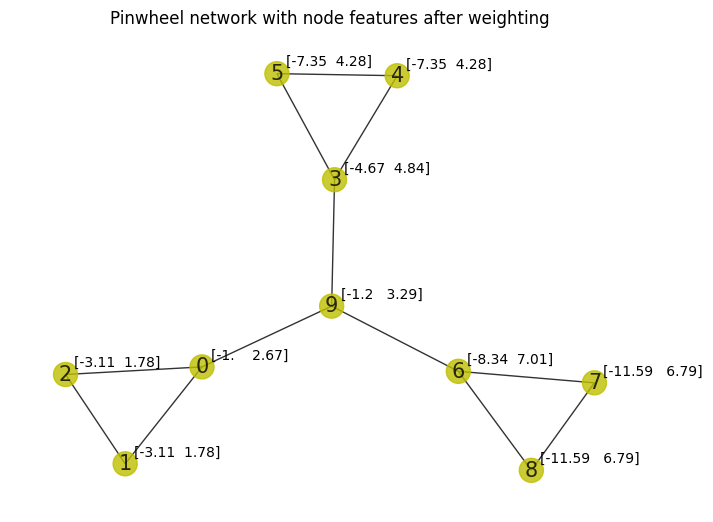

In [61]:
num_features_level0 = len(pinwheel_graph.nodes[1]["feature"])
num_features_level1 = 2
W = np.random.normal(size=(num_features_level0,num_features_level1))
H = np.linalg.inv(np.power(D,0.5))@A@np.linalg.inv(np.power(D,0.5))@X@W
plt.figure()
nx.draw(pinwheel_graph,pos,with_labels = True,node_color = colormap, node_size = 300,font_size = 15, alpha=0.8)
for node in pos.keys():
    plt.text(pos[node][0]+5, pos[node][1]+5, str(np.round(H[node,:],2)))
plt.title("Pinwheel network with node features after weighting")

__Aside: Why call it "convolutional"?__

The term "convolution" is a fancy way of saying "filter". The filters that we are using basically take information from a node and its neighbors and blend them together, creating a filtered version of what was there before. Using "convolution" in the term "Graph Convolutional Neural Network" in inspired by how neural networks used in image processing often take information from a pixel's neighbors and blend them together using the mathematical convolution operator. 

In the GCNs, we don't actually use the mathematical convolution operator, but we do use the idea of taking information from neighbors and blending them together. We just do it using the adjacency matrix. So the term "convolution" in a GCN is nice way to help people familiar with convolutional neural networks understand how a GCN works, but for the rest of us it's more metaphor than mathematical operator. 

__Aside: Checking the dimensions of the matrices__

When I'm dealing with big matrix products like the equation above, I often check the dimensions of each matrix. Let $n$ denote the number of nodes in the network, and let $f$ denote the number of features. Both $A$ and $D$ are $n\times n$. The feature matrix $x$ was constructured by stacking the row vectors of node features on top of each other, which means that matrix $X$ is $n\times f$. There are $f$ rows in the weight matrix $W$. We get to choose the number of columns, just like we chose the embedding dimension in deepwalk and node2vec. Let $d$ denote the dimension of the first hidden layer. Then the weight matrix $W$ has size $f\times d$. Putting the pieces together tells us that the matrix $H$ has size $n\times d$.

The size of the $W$ matrix gives us an insight about how hidden layers work. Because the weight matrix has size $f\times d$ you can think of this weight matrix as multiplying each row of $X$ by $W$. Interpreting $XW$ as each row of $X$ multiplied by $W$ means that each graph in the hidden layer from the figure above is weighted by the same amount. More sophisticated graph neural network models change this.


__Adding layers to the network__

Look again at the figure from Kipf's tutorial, which I'll replicate here for convenience.

<img src="figures/Kipf_figure.png" alt="Kipf GCN architecture" width = "600">

In effect, the first hidden layer tells a node "Aggregate information from your neighbors and blend it with your feature". This means that the first hidden layer only pays attention to immediate neighbors. I really hope that at this point in the class you realie that there is a lot of information relevant to a node not just from the node's neighbors but also from their neighbors and so on. The second hidden layer tells a node "You and your neighbors have just finished aggregating information from your immediate neighbors. Let's aggregate that new information again because that will pull in higher order graph structures, specifically the kind of information you get from deeper random walks in Deepwalk and Node2vec.

This has an important side effect for how many hidden layers get used in GCNs. We've learned that a node often wants information from our neighbors and from their neighbors and maybe even from their neighbors, but if we do this too much then we start to lose the local information that is really important for differentiating between nodes. The Stanford class suggests that three'ish hidden layers are often used in GCNs, but I haven't confirmed this.

__Notation for aggregating layers__

Following the example from both the Stanford class and from [Kipf's github description](https://tkipf.github.io/graph-convolutional-networks/), we'll use a superscript enclosed in parentheses to indicate which layer we are at. If we let the original feature vector be layer 0, then we can write $H^{0}=X$ and rewrite the equation above as

$$ H^{(1)} =  \tilde{D}^{-1/2} \tilde{A} \tilde{D}^{-1/2} H^{(0)} W^{(0)}$$

And we can write the value for each hidden layer in terms of the value of the previous hidden layer as

$$ H^{(\ell+1)} = \tilde{D}^{-1/2} \tilde{A} \tilde{D}^{-1/2} H^{(\ell)} W^{(\ell)} $$


Let's do the squashing with a sigmoid and inspect the feature vectors at the first hidden layer.

__Step 4: Transform Messages Part 2 -- Squashing.__

Before we move on to actually implementing this, we can't forget about the "squashing" part of the transformation. Squashing is really important if we want to incrementally aggregate information from larger and larger portions of the graph. Simply put, if we just keep doing matrix multiplications at each layer, that's just the same as doing one really big matrix multiplication. Since we are trying to learn the values in the weight matrix, we've really reduced the number of parameters that we can tweak to see interesting patterns. Additionally, we can only learn linear features of the world, which isn't very powerful for many interesting problems.  Squashing adds a nonlinearity in between matrix multiplications, which kind of "keeps separate" the values in the different matrices and allows more interesting structures to be learned.


My mental model for how the weighting and squashing occur is based on figures like the one from Kipf above. In the figure, the weighting occurs on the edges between one layer and the next, and the squashing occurs at the layer. In Ellenberg's book "Shape: The Hidden Geometry of Information, Biology, Strategy, Democracy, and Everything Else" he makes an important observation about why people use the squashing functions that they use. First, they allow gradients to be computed, and that is important because the matrix weights are tuned through a gradient-like process that corrects errors. Second, they just happen to work for a bunch of problems, and nobody is too sure about which problems they don't work on.



Here are some references to some common squashing functions. I'm not going to write about them, just use them.


 - Hidden layers.
   - [Recitified linear units](https://en.wikipedia.org/wiki/Rectifier_\(neural_networks\)) (relu). These units essentially get rid of values less than zero. The reasoning behind using them is that if a feature vector has all values between zero and one then you shouldn't have any negative values in the layers that are "aggregating and transforming" those features.
   - [Hyperbolic tangent](https://en.wikipedia.org/wiki/Activation_function) (tanh). These functions squash everythng 
   - [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function). The sigmoid function also squishes all values so that they are between zero and one, but you can't interpret the result as a probability. 
 - Output layer.
   - [Soft max](https://en.wikipedia.org/wiki/Softmax_function). Soft max squishes all values so that they are between zero and one. The outputs of these functions can be interpreted as probabilities, which is what we did when we implemented deepwalk and node2vec. If we are asking the GCN to give us a node embedding, then use softmax.
   - [Linear](https://en.wikipedia.org/wiki/Activation_function). This function just returns whatever is computed from the weights. It's a convenient way of seeing an embedding without squashing it.
   - [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function). The sigmoid function also squishes all values so that they are between zero and one, but you can't interpret the result as a probability. 


Text(0.5, 1.0, 'Pinwheel network with features after squashing with sigmoid')

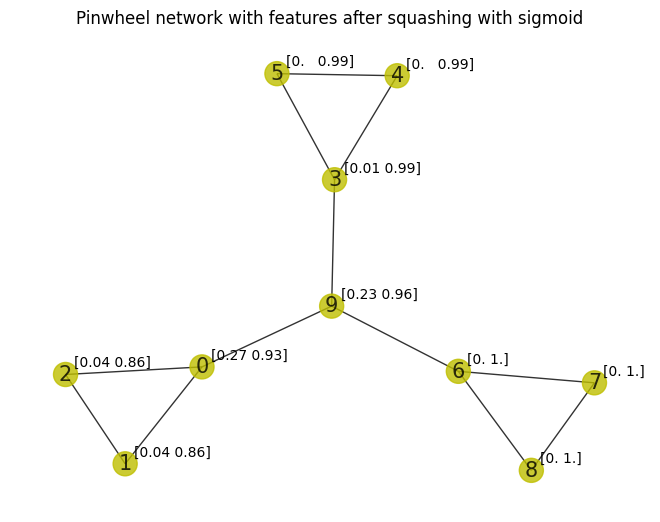

In [62]:
from scipy.special import expit # Sigmoid
H = expit(H)
nx.draw(pinwheel_graph,pos,with_labels = True,node_color = colormap, node_size = 300,font_size = 15, alpha=0.8)
for node in pos.keys():
    plt.text(pos[node][0]+5, pos[node][1]+5, str(np.round(H[node,:],2)))
plt.title("Pinwheel network with features after squashing with sigmoid")

Notice how all values are now between 0 and 1. 

__Hidden Layers__

As we look at the examples in the next part of the tutorial, look for the pattern:

 - weight
 - squash
 - weight
 - squash

which is all that the hidden layers do. We'll have to define the dimension of the weight matrix and the function that does the squashing, so look for that.


__Step 5: The Output Layer__

The output layer is a little different because it depends on what we are trying to accomplish. For this tutorial, we'll only consider two types of outputs: embeddings and labeling nodes. 

The word embeddings in the GCN context means the same thing that it did when we used the term in spectral embeddings, in Deepwalk, and in Node2vec: a vector space representation of the nodes. 

Node labeling is a _semi-supervised_ learning task. The idea is that someone gives us a network with a bunch of features and a few nodes that were labeled by a human. The "supervised" part of "semi-supervised" means that a human has figured out what the label should be associated with the features for a few nodes. The "semi" part means that the network has to figure out the other labels.

We'll see that embeddings can be derived from two different types of training data:
 - a graph with some nodes that are labeled and that are used to train the neural network, and
 - a graph with no labeled nodes and that are "trained" by
   - running a regular GCN hidden layer to create a lower dimensional embedding, and
   -  then running that low-dimensional embedding through another layer that tries to replicate the original adjacency matrix.

---



### Real-world Example

I asked ChatGPT 4.o to help me construct a real-world example. The specifications I gave it were that I needed 
- Three authors of childrens stories whose work is in the public domain
- Each author must have at least three stories
- Each story must have something in common with the other stories

I also asked for an article of blog that summarized similarities and differences among the stories. It hallucinated a response, but the response serves the purpose that I need so I'll use it.  I asked for a summary in csv so that I could read it into a pandas dataframe

<img src="figures/Transformer_ready_childrens_stories.png" alt="Summary of children's stories for node labels" width = "800">

In [63]:
import pandas as pd

# Load transformer-ready CSV
df: pd.DataFrame = pd.read_csv("datasets/Transformer_Ready_Stories_With_Node0.csv")
df.head()

,author,title,text
0,Beatrix Potter,The Tale of Peter Rabbit,The Tale of Peter Rabbit: Once upon a time the...
1,Beatrix Potter,The Tale of Benjamin Bunny,The Tale of Benjamin Bunny: One morning a litt...
2,Beatrix Potter,The Tale of Jemima Puddle-Duck,The Tale of Jemima Puddle-Duck: What a funny s...
3,Rudyard Kipling,Mowgli’s Brothers (from The Jungle Book),Mowgli’s Brothers (from The Jungle Book): Now ...
4,Rudyard Kipling,Kaa’s Hunting,Kaa’s Hunting: His spots are the joy of the Le...


Use a transformer to turn the information in this dataset into a feature vector for each node in the pinwheel network.

In [64]:
from sentence_transformers import SentenceTransformer
from numpy.typing import NDArray

## Requires pip install sentence-tranformers


# Load model
model: SentenceTransformer = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Create embeddings
embeddings: NDArray = model.encode(df["text"].tolist(), show_progress_bar=True)

Batches: 100%|██████████| 1/1 [00:00<00:00, 27.73it/s]


Create pinwheel network and label each node one summary of story

In [79]:
import networkx as nx

# Create the graph
G = nx.Graph()
G.add_nodes_from(range(10))
G.add_edges_from([
    (1,2), (1,3), (2,3),
    (4,5), (4,6), (5,6),
    (7,8), (7,9), (8,9),
    (1,0), (4,0), (7,0)
])

# Label nodes with stroy name
# Node mapping: [0] is summary, [1-3] Potter, [4-6] Aesop, [7-9] Kipling
node_map = {
    0: "Common Themes",   # summary (last row)
    1: "Peter Rabbit", 2: "Benjamin Bunny", 3: "Jemima Puddle-Duck",  # Beatrix Potter
    4: "Tortoise and Hare", 5: "Fox and Grapes", 6: "Lion and Mouse",  # Aesop's Fables
    7: "Mowgli's Brothers", 8: "Kaa's Hunting", 9: "Tiger! Tiger!",  # Rudyard Kipling
}

Add embedding attribute to each node

In [80]:
# Assign embeddings to nodes
# Node mapping: [0] is summary, [1-3] Potter, [4-6] Aesop, [7-9] Kipling
embedding_map = {
    0: 9,   # summary (last row)
    1: 0, 2: 1, 3: 2,  # Beatrix Potter
    4: 6, 5: 7, 6: 8,  # Aesop's Fables
    7: 3, 8: 4, 9: 5   # Rudyard Kipling
}

# Assign each graph node an embedding attribute
for node, idx in embedding_map.items():
    G.nodes[node]["embedding"] = embeddings[idx]

# Inspect node 1's vector
print(G.nodes[1]["embedding"])

[-0.00942438  0.0856192  -0.02222105  0.02069621 -0.2597679  -0.07843474
  0.22576557 -0.41814822  0.37197062  0.18938565  0.2053465   0.16877471
  0.07024512  0.13838132 -0.37497076  0.2959573  -0.499824   -0.02146321
 -0.03790282 -0.05380126 -0.10715245  0.07044859  0.30558535 -0.20260124
 -0.18777819  0.11627196  0.07965963 -0.14293869 -0.01645883 -0.20721994
 -0.04354628  0.11411884  0.10128479 -0.2895519   0.11491045  0.28467032
 -0.20954545 -0.02741092  0.5035257   0.16052504  0.35871345  0.12208457
  0.35720044 -0.18541957 -0.3403333   0.12989631 -0.21295077  0.19034086
 -0.14056091  0.12240681 -0.19863923 -0.06602476 -0.21175028 -0.16001467
  0.18668558 -0.00260319 -0.08679498 -0.24880594 -0.09348982 -0.08824312
  0.08826847  0.14857921  0.18508348  0.20064746  0.20096213  0.05488074
 -0.5501293  -0.12628998  0.05348993  0.04473872 -0.31169257  0.27312908
  0.04239016  0.08209335 -0.1443585   0.06808191 -0.18634526 -0.17253952
 -0.09328248 -0.08490136 -0.41803792  0.21565305  0

---

### Run through a graph convolutional neural network

Get data from graph into a tensor. Code from ChatGPT-4.o

In [81]:
## Requires "pip install torch torchvision torchaudio"
## Requires "pip install torch_geometric"

import torch
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx

# Step 1.1: Convert embeddings to torch tensors and attach as node features
for node in G.nodes:
    G.nodes[node]["x"] = torch.tensor(G.nodes[node]["embedding"], dtype=torch.float)

# Step 1.2: Convert to PyG Data object
data = from_networkx(G)
data.x = torch.stack([data.x[i] for i in range(data.num_nodes)])  # (num_nodes, embedding_dim)

Define the model. Choices of parameters made in conjunction with ChatGPT-4.o

In [82]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class ThreeLayerGCN(nn.Module):
    def __init__(self, in_channels: int, hidden_channels: int, out_channels: int):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)

    def forward(self, data: Data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = self.conv3(x, edge_index)
        return x

Run the model. Code from ChatGPT-4.o

In [83]:
in_dim = data.x.shape[1]        # e.g. 384 for MiniLM
hidden_dim = 64
out_dim = 32                    # final embedding size for nodes

model = ThreeLayerGCN(in_dim, hidden_dim, out_dim)

# Forward pass
with torch.no_grad():
    node_embeddings = model(data)  # Shape: [10, 32]
    print(node_embeddings.shape)

torch.Size([10, 32])


---

#### Compress, visualize, and classify nodes

**Compress using TSNE**

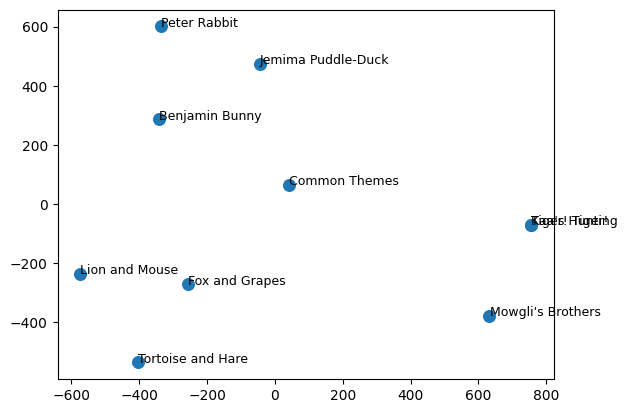

In [84]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
def visualize(Z, node_map):
    z = TSNE(n_components=2, perplexity = 5).fit_transform(Z)
    _ = plt.scatter(z[:, 0], z[:, 1], s=70)
    for i, (x, y) in enumerate(z):
        label = node_map.get(i, str(i))  # fallback to node number if not in map
        plt.text(x + 0.5, y, label, fontsize=9)

visualize(node_embeddings, node_map)

**Use knn to find clusters**

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


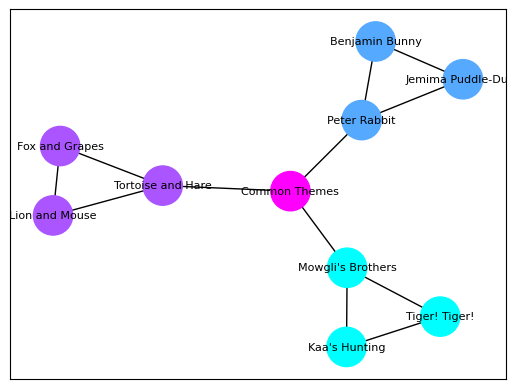

In [89]:
from sklearn.cluster import KMeans
kmeans = KMeans(
    init="random",
    n_clusters=4,
    n_init=10,
    random_state=1234
    )

# Cluster in higher dimensional space. Just use TSNE for visualization

kmeans.fit(node_embeddings)
#print(kmeans.labels_)
nx.draw_networkx(G, 
                 #pos=nx.spring_layout(G,seed=0), 
                 pos = nx.nx_pydot.graphviz_layout(G,prog="neato"),
                 node_color=kmeans.labels_,
                 node_size=800,
                 cmap='cool',
                 labels=node_map,
                 font_size=8,
                 font_color='black')